In [1]:
import time
import argparse
import logging
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
from scipy.stats import gmean

import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from tensorboard_logger import Logger
import matplotlib.pyplot as plt

from resnet import resnet50
from loss import *
from datasets import AgeDB
from utils import *

import os

In [2]:
from types import SimpleNamespace

imbalanced_related = {"dataset": "agedb", "start_epoch": 0, "epoch": 10, "best_loss": 1e5, "lr": 1e-3,
                      "data_dir": "./data", "schedule": [60, 80], "loss": "l1", "print_freq" : 1, "evaluate": "",
                      "fds": False, "bucket_num": 100, "bucket_start": 3, "start_update": 0, "resume": "",
                      "start_smooth": 1, "fds_kernel": "gaussian", "fds_ks": 9, "fds_sigma": 1, "pretrained": "",
                      "fds_mmt": 0.9, "retrain_fc": False, "img_size": 224, "reweight": "sqrt_inv", "optimizer": "adam",
                      "lds": True, "lds_kernel": "gaussian", "lds_ks": 5, "lds_sigma": 2, "model": "resnet50",
                      "batch_size": 256, "workers": 8, "store_root": "./checkpoints", "store_name": "lds_model"
                     }
args = SimpleNamespace(**imbalanced_related)

In [3]:
if len(args.store_name):
    args.store_name = f'_{args.store_name}'
if not args.lds and args.reweight != 'none':
    args.store_name += f'_{args.reweight}'
if args.lds:
    args.store_name += f'_lds_{args.lds_kernel[:3]}_{args.lds_ks}'
    if args.lds_kernel in ['gaussian', 'laplace']:
        args.store_name += f'_{args.lds_sigma}'
if args.fds:
    args.store_name += f'_fds_{args.fds_kernel[:3]}_{args.fds_ks}'
    if args.fds_kernel in ['gaussian', 'laplace']:
        args.store_name += f'_{args.fds_sigma}'
    args.store_name += f'_{args.start_update}_{args.start_smooth}_{args.fds_mmt}'
if args.retrain_fc:
    args.store_name += f'_retrain_fc'
args.store_name = f"{args.dataset}_{args.model}{args.store_name}_{args.optimizer}_{args.loss}_{args.lr}_{args.batch_size}"

prepare_folders(args)

logging.root.handlers = []
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(message)s",
    handlers=[
        logging.FileHandler(os.path.join(args.store_root, args.store_name, 'training.log')),
        logging.StreamHandler()
    ])
print = logging.info
print(f"Args: {args}")
print(f"Store name: {args.store_name}")

tb_logger = Logger(logdir=os.path.join(args.store_root, args.store_name), flush_secs=2)

2022-01-20 23:58:43,273 | Args: namespace(batch_size=256, best_loss=100000.0, bucket_num=100, bucket_start=3, data_dir='./data', dataset='agedb', epoch=10, evaluate='', fds=False, fds_kernel='gaussian', fds_ks=9, fds_mmt=0.9, fds_sigma=1, img_size=224, lds=True, lds_kernel='gaussian', lds_ks=5, lds_sigma=2, loss='l1', lr=0.001, model='resnet50', optimizer='adam', pretrained='', print_freq=1, resume='', retrain_fc=False, reweight='sqrt_inv', schedule=[60, 80], start_epoch=0, start_smooth=1, start_update=0, store_name='agedb_resnet50_lds_model_lds_gau_5_2_adam_l1_0.001_256', store_root='./checkpoints', workers=8)
2022-01-20 23:58:43,274 | Store name: agedb_resnet50_lds_model_lds_gau_5_2_adam_l1_0.001_256


===> Creating folder: ./checkpoints/agedb_resnet50_lds_model_lds_gau_5_2_adam_l1_0.001_256


In [4]:
if args.resume:
    if os.path.isfile(args.resume):
        print(f"===> Loading checkpoint '{args.resume}'")
        checkpoint = torch.load(args.resume) if args.gpu is None else \
            torch.load(args.resume, map_location=torch.device(f'cuda:{str(args.gpu)}'))
        args.start_epoch = checkpoint['epoch']
        args.best_loss = checkpoint['best_loss']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print(f"===> Loaded checkpoint '{args.resume}' (Epoch [{checkpoint['epoch']}])")
    else:
        print(f"===> No checkpoint found at '{args.resume}'")
        
else:
    print("===> Resume is disabled")


2022-01-20 23:58:47,531 | ===> Resume is disabled


In [5]:
def get_hist_of_age(bins,ages):
    plt.style.use('ggplot')
    fig=plt.figure(figsize=(16,6))

    plt.hist(ages, bins = bins, edgecolor = 'black')

    plt.xlabel("Age")
    plt.ylabel("Age Disribution")
    plt.title("Age Distribution Histogram")
    plt.show()

In [6]:
# Data
print('=====> Preparing data...')
print(f"File (.csv): {args.dataset}.csv")
df = pd.read_csv(os.path.join(args.data_dir, f"{args.dataset}.csv"))
df_train, df_val, df_test = df[df['split'] == 'train'], df[df['split'] == 'val'], df[df['split'] == 'test']
train_labels = df_train['age']

2022-01-20 23:58:49,618 | =====> Preparing data...
2022-01-20 23:58:49,619 | File (.csv): agedb.csv


In [7]:
print(df.head())

2022-01-20 23:58:51,208 |    age                                path  split
0   31   AgeDB/11706_OliviaHussey_31_f.jpg  train
1   59   AgeDB/11684_MireilleDarc_59_f.jpg    val
2   44   AgeDB/7955_GilbertRoland_44_m.jpg  train
3   61  AgeDB/9352_GeorgesMarchal_61_m.jpg    val
4   28     AgeDB/3888_TomasMilian_28_m.jpg    val


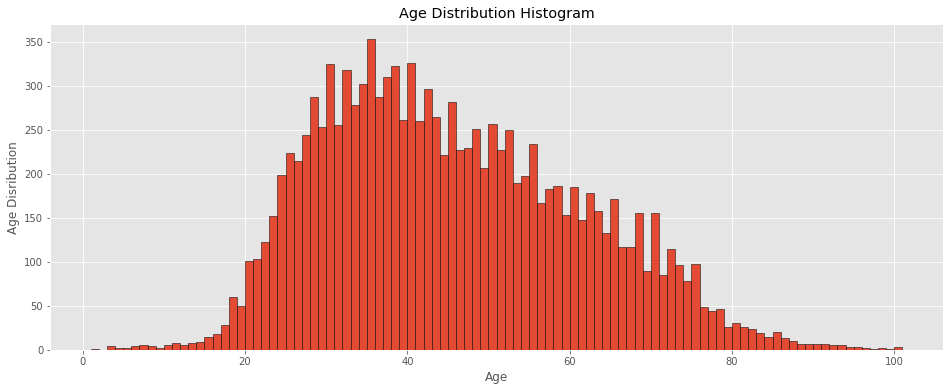

In [8]:
# Train Data for Age
get_hist_of_age(bins=100, ages = train_labels)

2022-01-20 23:58:53,708 | Using re-weighting: [SQRT_INV]
2022-01-20 23:58:53,708 | Using LDS: [GAUSSIAN] (5/2)


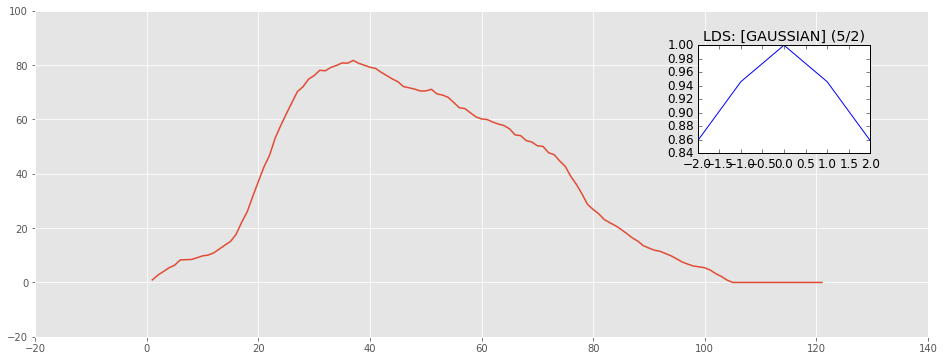

In [9]:
# Load Data Sets and See the Kernel and Effective Label Density after convolution to make the Emprical LD smoothe
train_dataset = AgeDB(data_dir=args.data_dir, df=df_train, img_size=args.img_size, split='train',reweight=args.reweight, lds=args.lds, lds_kernel=args.lds_kernel, lds_ks=args.lds_ks, lds_sigma=args.lds_sigma)
val_dataset = AgeDB(data_dir=args.data_dir, df=df_val, img_size=args.img_size, split='val')
test_dataset = AgeDB(data_dir=args.data_dir, df=df_test, img_size=args.img_size, split='test')

In [10]:
# Loaders
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,
                          num_workers=args.workers, pin_memory=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False,
                        num_workers=args.workers, pin_memory=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False,
                         num_workers=args.workers, pin_memory=True, drop_last=False)

In [11]:
# Observe sizes
print(f"Training data size: {len(train_dataset)}")
print(f"Validation data size: {len(val_dataset)}")
print(f"Test data size: {len(test_dataset)}")

2022-01-20 23:58:56,368 | Training data size: 12208
2022-01-20 23:58:56,369 | Validation data size: 2140
2022-01-20 23:58:56,369 | Test data size: 2140


In [12]:
# Model
print('=====> Building model...')
model = resnet50(fds=args.fds, bucket_num=args.bucket_num, bucket_start=args.bucket_start,
                 start_update=args.start_update, start_smooth=args.start_smooth,
                 kernel=args.fds_kernel, ks=args.fds_ks, sigma=args.fds_sigma, momentum=args.fds_mmt)
model = torch.nn.DataParallel(model)
print(model)

2022-01-20 23:58:57,498 | =====> Building model...
2022-01-20 23:58:58,212 | DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [13]:
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

In [14]:
def train(train_loader, model, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.2f')
    data_time = AverageMeter('Data', ':6.4f')
    losses = AverageMeter(f'Loss ({args.loss.upper()})', ':.3f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses],
        prefix="Epoch: [{}]".format(epoch)
    )

    print("Training...")
    model.train()
    end = time.time()
    print("Load train loader")
    for idx, (inputs, targets, weights) in enumerate(train_loader):
        data_time.update(time.time() - end)
        print("===> Batch : " + str(idx+1))
        #inputs, targets, weights = \
        #    inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True), weights.cuda(non_blocking=True)
        if args.fds:
            print("FDS enable")
            outputs, _ = model(inputs, targets, epoch)
        else:
            print("FDS disable")
            outputs = model(inputs, targets, epoch)

        print("Calculate Loss")
        loss = globals()[f"weighted_{args.loss}_loss"](outputs, targets, weights)
        assert not (np.isnan(loss.item()) or loss.item() > 1e6), f"Loss explosion: {loss.item()}"

        print("Update Loss")
        losses.update(loss.item(), inputs.size(0))

        optimizer.zero_grad()
        print("Backward")
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()
        if idx % args.print_freq == 0:
            progress.display(idx+1)

    if args.fds and epoch >= args.start_update:
        print(f"Create Epoch [{epoch}] features of all training data...")
        encodings, labels = [], []
        with torch.no_grad():
            for (inputs, targets, _) in tqdm(train_loader):
                #inputs = inputs.cuda(non_blocking=True)
                outputs, feature = model(inputs, targets, epoch)
                encodings.extend(feature.data.squeeze().cpu().numpy())
                labels.extend(targets.data.squeeze().cpu().numpy())

        encodings, labels = torch.from_numpy(np.vstack(encodings)), torch.from_numpy(np.hstack(labels))
        model.module.FDS.update_last_epoch_stats(epoch)
        model.module.FDS.update_running_stats(encodings, labels, epoch)

    return losses.avg

In [15]:
def validate(val_loader, model, train_labels=None, prefix='Val'):
    batch_time = AverageMeter('Time', ':6.3f')
    losses_mse = AverageMeter('Loss (MSE)', ':.3f')
    losses_l1 = AverageMeter('Loss (L1)', ':.3f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses_mse, losses_l1],
        prefix=f'{prefix}: '
    )

    criterion_mse = nn.MSELoss()
    criterion_l1 = nn.L1Loss()
    criterion_gmean = nn.L1Loss(reduction='none')

    model.eval()
    losses_all = []
    preds, labels = [], []
    with torch.no_grad():
        end = time.time()
        for idx, (inputs, targets, _) in enumerate(val_loader):
            #inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
            outputs = model(inputs)

            preds.extend(outputs.data.cpu().numpy())
            labels.extend(targets.data.cpu().numpy())

            loss_mse = criterion_mse(outputs, targets)
            loss_l1 = criterion_l1(outputs, targets)
            loss_all = criterion_gmean(outputs, targets)
            losses_all.extend(loss_all.cpu().numpy())

            losses_mse.update(loss_mse.item(), inputs.size(0))
            losses_l1.update(loss_l1.item(), inputs.size(0))

            batch_time.update(time.time() - end)
            end = time.time()
            if idx % args.print_freq == 0:
                progress.display(idx)

        shot_dict = shot_metrics(np.hstack(preds), np.hstack(labels), train_labels)
        loss_gmean = gmean(np.hstack(losses_all), axis=None).astype(float)
        print(f" * Overall: MSE {losses_mse.avg:.3f}\tL1 {losses_l1.avg:.3f}\tG-Mean {loss_gmean:.3f}")
        print(f" * Many: MSE {shot_dict['many']['mse']:.3f}\t"
              f"L1 {shot_dict['many']['l1']:.3f}\tG-Mean {shot_dict['many']['gmean']:.3f}")
        print(f" * Median: MSE {shot_dict['median']['mse']:.3f}\t"
              f"L1 {shot_dict['median']['l1']:.3f}\tG-Mean {shot_dict['median']['gmean']:.3f}")
        print(f" * Low: MSE {shot_dict['low']['mse']:.3f}\t"
              f"L1 {shot_dict['low']['l1']:.3f}\tG-Mean {shot_dict['low']['gmean']:.3f}")

    return losses_mse.avg, losses_l1.avg, loss_gmean


In [16]:
def shot_metrics(preds, labels, train_labels, many_shot_thr=100, low_shot_thr=20):
    train_labels = np.array(train_labels).astype(int)

    if isinstance(preds, torch.Tensor):
        preds = preds.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
    elif isinstance(preds, np.ndarray):
        pass
    else:
        raise TypeError(f'Type ({type(preds)}) of predictions not supported')

    train_class_count, test_class_count = [], []
    mse_per_class, l1_per_class, l1_all_per_class = [], [], []
    for l in np.unique(labels):
        train_class_count.append(len(train_labels[train_labels == l]))
        test_class_count.append(len(labels[labels == l]))
        mse_per_class.append(np.sum((preds[labels == l] - labels[labels == l]) ** 2))
        l1_per_class.append(np.sum(np.abs(preds[labels == l] - labels[labels == l])))
        l1_all_per_class.append(np.abs(preds[labels == l] - labels[labels == l]))

    many_shot_mse, median_shot_mse, low_shot_mse = [], [], []
    many_shot_l1, median_shot_l1, low_shot_l1 = [], [], []
    many_shot_gmean, median_shot_gmean, low_shot_gmean = [], [], []
    many_shot_cnt, median_shot_cnt, low_shot_cnt = [], [], []

    for i in range(len(train_class_count)):
        if train_class_count[i] > many_shot_thr:
            many_shot_mse.append(mse_per_class[i])
            many_shot_l1.append(l1_per_class[i])
            many_shot_gmean += list(l1_all_per_class[i])
            many_shot_cnt.append(test_class_count[i])
        elif train_class_count[i] < low_shot_thr:
            low_shot_mse.append(mse_per_class[i])
            low_shot_l1.append(l1_per_class[i])
            low_shot_gmean += list(l1_all_per_class[i])
            low_shot_cnt.append(test_class_count[i])
        else:
            median_shot_mse.append(mse_per_class[i])
            median_shot_l1.append(l1_per_class[i])
            median_shot_gmean += list(l1_all_per_class[i])
            median_shot_cnt.append(test_class_count[i])

    shot_dict = defaultdict(dict)
    shot_dict['many']['mse'] = np.sum(many_shot_mse) / np.sum(many_shot_cnt)
    shot_dict['many']['l1'] = np.sum(many_shot_l1) / np.sum(many_shot_cnt)
    shot_dict['many']['gmean'] = gmean(np.hstack(many_shot_gmean), axis=None).astype(float)
    shot_dict['median']['mse'] = np.sum(median_shot_mse) / np.sum(median_shot_cnt)
    shot_dict['median']['l1'] = np.sum(median_shot_l1) / np.sum(median_shot_cnt)
    shot_dict['median']['gmean'] = gmean(np.hstack(median_shot_gmean), axis=None).astype(float)
    shot_dict['low']['mse'] = np.sum(low_shot_mse) / np.sum(low_shot_cnt)
    shot_dict['low']['l1'] = np.sum(low_shot_l1) / np.sum(low_shot_cnt)
    shot_dict['low']['gmean'] = gmean(np.hstack(low_shot_gmean), axis=None).astype(float)

    return shot_dict

In [17]:
for epoch in range(args.start_epoch, args.epoch):
        adjust_learning_rate(optimizer, epoch, args)
        train_loss = train(train_loader, model, optimizer, epoch)
        val_loss_mse, val_loss_l1, val_loss_gmean = validate(val_loader, model, train_labels=train_labels)

        loss_metric = val_loss_mse if args.loss == 'mse' else val_loss_l1
        is_best = loss_metric < args.best_loss
        args.best_loss = min(loss_metric, args.best_loss)
        print(f"Best {'L1' if 'l1' in args.loss else 'MSE'} Loss: {args.best_loss:.3f}")
        save_checkpoint(args, {
            'epoch': epoch + 1,
            'model': args.model,
            'best_loss': args.best_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, is_best)
        print(f"Epoch #{epoch}: Train loss [{train_loss:.4f}]; "
              f"Val loss: MSE [{val_loss_mse:.4f}], L1 [{val_loss_l1:.4f}], G-Mean [{val_loss_gmean:.4f}]")
        tb_logger.log_value('train_loss', train_loss, epoch)
        tb_logger.log_value('val_loss_mse', val_loss_mse, epoch)
        tb_logger.log_value('val_loss_l1', val_loss_l1, epoch)
        tb_logger.log_value('val_loss_gmean', val_loss_gmean, epoch)

2022-01-20 23:59:04,244 | Training...
2022-01-20 23:59:04,246 | Load train loader
2022-01-20 23:59:05,521 | ===> Batch : 1
2022-01-20 23:59:05,525 | FDS disable
2022-01-20 23:59:18,265 | Calculate Loss
2022-01-20 23:59:18,266 | Update Loss
2022-01-20 23:59:18,267 | Backward
2022-01-20 23:59:40,415 | Epoch: [0][ 1/48]	Time  36.17 ( 36.17)	Data 1.2754 (1.2754)	Loss (L1) 49.130 (49.130)
2022-01-20 23:59:40,427 | ===> Batch : 2
2022-01-20 23:59:40,428 | FDS disable
2022-01-20 23:59:52,471 | Calculate Loss
2022-01-20 23:59:52,472 | Update Loss
2022-01-20 23:59:52,476 | Backward
2022-01-21 00:00:14,306 | Epoch: [0][ 2/48]	Time  33.89 ( 35.03)	Data 0.0126 (0.6440)	Loss (L1) 47.247 (48.189)
2022-01-21 00:00:14,319 | ===> Batch : 3
2022-01-21 00:00:14,320 | FDS disable
2022-01-21 00:00:26,401 | Calculate Loss
2022-01-21 00:00:26,403 | Update Loss
2022-01-21 00:00:26,406 | Backward
2022-01-21 00:00:47,599 | Epoch: [0][ 3/48]	Time  33.29 ( 34.45)	Data 0.0128 (0.4336)	Loss (L1) 40.784 (45.720)
202

In [18]:
checkpoint = torch.load(f"checkpoints/agedb_resnet50_lds_model_lds_gau_5_2_adam_l1_0.001_256/ckpt.best.pth.tar")

In [19]:
# test with best checkpoint
print("=" * 120)
print("Test best model on testset...")
#checkpoint = torch.load(f"{args.store_root}/{args.store_name}/ckpt.best.pth.tar")
model.load_state_dict(checkpoint['state_dict'])
print(f"Loaded best model, epoch {checkpoint['epoch']}, best val loss {checkpoint['best_loss']:.4f}")
test_loss_mse, test_loss_l1, test_loss_gmean = validate(test_loader, model, train_labels=train_labels, prefix='Test')
print(f"Test loss: MSE [{test_loss_mse:.4f}], L1 [{test_loss_l1:.4f}], G-Mean [{test_loss_gmean:.4f}]\nDone")

2022-01-21 06:04:47,393 | ========================================================================================================================
2022-01-21 06:04:47,394 | Test best model on testset...
2022-01-21 06:04:47,420 | Loaded best model, epoch 10, best val loss 12.0250
2022-01-21 06:04:59,119 | Test: [0/9]	Time 11.697 (11.697)	Loss (MSE) 238.094 (238.094)	Loss (L1) 12.173 (12.173)
2022-01-21 06:05:08,269 | Test: [1/9]	Time  9.150 (10.424)	Loss (MSE) 217.145 (227.619)	Loss (L1) 11.304 (11.739)
2022-01-21 06:05:17,389 | Test: [2/9]	Time  9.120 ( 9.989)	Loss (MSE) 230.445 (228.561)	Loss (L1) 11.759 (11.745)
2022-01-21 06:05:26,543 | Test: [3/9]	Time  9.154 ( 9.780)	Loss (MSE) 219.687 (226.343)	Loss (L1) 11.512 (11.687)
2022-01-21 06:05:35,754 | Test: [4/9]	Time  9.211 ( 9.666)	Loss (MSE) 243.862 (229.847)	Loss (L1) 12.019 (11.753)
2022-01-21 06:05:44,873 | Test: [5/9]	Time  9.119 ( 9.575)	Loss (MSE) 218.309 (227.924)	Loss (L1) 11.533 (11.717)
2022-01-21 06:05:54,073 | Test: [6/9

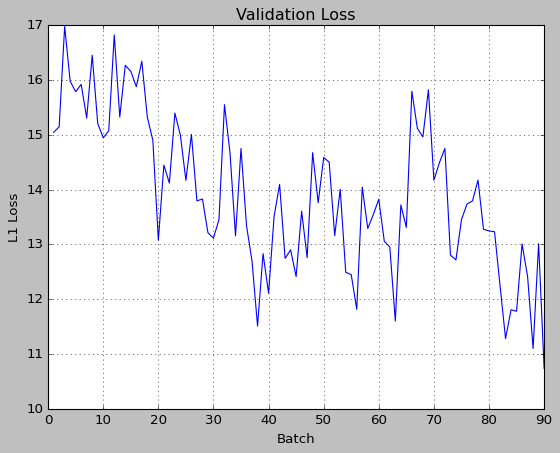

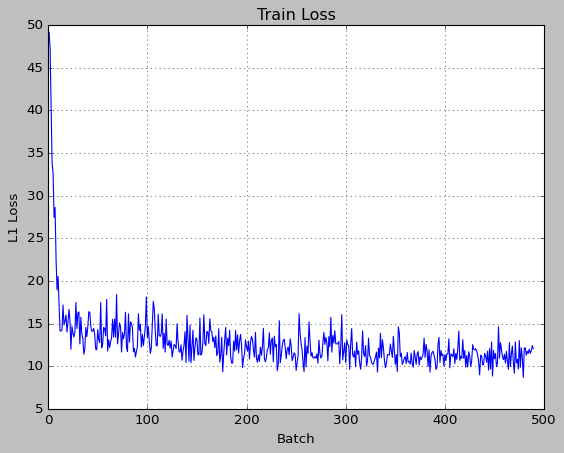

In [20]:
import re
import numpy as np
import matplotlib.pyplot as plt

# This cell is to plot the both train and validation losses . It finds the training log by passing the p
# path in the related file in the checkpoint directory.
# After it finds , it parses the L1 values according to the given mode option
# param : train (default) ===> plots the losses wrt train data
# ----- 
# param : Val  ===> plots the losses wrt validation data
# ----- 

def plotModel(vals,title,xtitle,ytitle,grid = False):
    batch = np.arange(len(vals)) + 1
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    plt.grid(grid)
    plt.plot(batch,vals)
    plt.show()
    
def getL1Losses(Lines, mod = "train"):
    l1_values = []
    for line in Lines:
        if "(L1)" in line:
            strr = re.sub(r"\s+", "", line)
            if mod == "Val":
                if mod in strr:
                    start = strr.find('(L1)')
                    end = strr.rfind("(")
                    l1 = strr[start+4:end]
                    l1_values.append(float(l1))
            else:
                if "Val" not in strr:
                    start = strr.find('(L1)')
                    end = strr.rfind("(")
                    l1 = strr[start+4:end]
                    l1_values.append(float(l1))
                
    return l1_values

def getLinesFromTextFile(path):
    all_path = '/home/candoga01/' + path
    file1 = open(all_path, 'r')
    return file1.readlines()


path = 'blg_561e_project/agedb-dir/checkpoints/agedb_resnet50_lds_model_lds_gau_5_2_adam_l1_0.001_256/training.log'


# Data for Val
lines = getLinesFromTextFile(path)
l1_values_val = getL1Losses(lines,mod="Val")

# Data for Train
lines = getLinesFromTextFile(path)
l1_values_train = getL1Losses(lines)

plotModel(l1_values_val,"Validation Loss","Batch","L1 Loss",True)
plotModel(l1_values_train,"Train Loss","Batch","L1 Loss",True)